## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde

######################
# ITER shape #
######################
eps_deviation = 0.1
kappa_deviation = 0.1
delta_deviation = 0.1
eps0 = (0.32 - eps_deviation, 0.32 + eps_deviation)
kappa0 = (1.7 - kappa_deviation, 1.7 + kappa_deviation)
delta0 = (0.33 - delta_deviation, 0.33 + delta_deviation)
Amax = 0.1
num_param = 5
Arange = np.linspace(-Amax, Amax, num_param)
eps = np.linspace(eps0[0], eps0[1], num_param)
kappa = np.linspace(kappa0[0], kappa0[1], num_param)
delta = np.linspace(delta0[0], delta0[1], num_param)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################

    N = num
    center = np.array(
        [[0.0, 0.0, 0.0, 
          eps0[1] - eps0[0], 
          kappa0[1] - kappa0[0],
          delta0[1] - delta0[0]]]
    )
    tau = np.linspace(0, 2 * np.pi, N)
    R_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    Z_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    A_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    eps_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    kappa_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    delta_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    for i in range(num_param):
        for j in range(num_param):
            for k in range(num_param):
                for kk in range(num_param):
                    R_ellipse[:, i, j, k, kk] = 1 + eps[j] * np.cos(tau + np.arcsin(delta[kk]) * np.sin(tau))
                    Z_ellipse[:, i, j, k, kk] = eps[j] * kappa[k] * np.sin(tau)
                    A_ellipse[:, i, j, k, kk] = Arange[i]
                    eps_ellipse[:, i, j, k, kk] = eps[j]
                    kappa_ellipse[:, i, j, k, kk] = kappa[k]
                    delta_ellipse[:, i, j, k, kk] = delta[kk]
    
    x_ellipse = np.transpose(
        np.asarray([
            R_ellipse, Z_ellipse, A_ellipse, 
            eps_ellipse, kappa_ellipse, delta_ellipse]), 
                             [1, 2, 3, 4, 5, 0])
    x_ellipse = x_ellipse.reshape(N * num_param ** 4, 6)

    print(x_ellipse.shape)
    uvals = np.zeros(len(x_ellipse)).reshape(len(x_ellipse), 1)
    return x_ellipse, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    A = x[:, 2:3]
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)


spatial_domain = dde.geometry.HyperEllipticalToroid(eps0, kappa0, delta0, Amax=Amax) 

x, u = gen_traindata(100)

n_test = 100
x_test,u_test = gen_traindata(n_test)
x_domain = spatial_domain.random_points(n_test)
x_test = np.concatenate((x_test, x_domain))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=2048,
    num_boundary=0,
    x_test=x_test,
    y_test=u_test,
    train_distribution="LHS"
)


Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term
(62500, 6)
(62500, 6)


In [2]:
data.train_x_bc.shape

(62500, 6)

Text(0.5, 0, '$u(r,z=0)$')

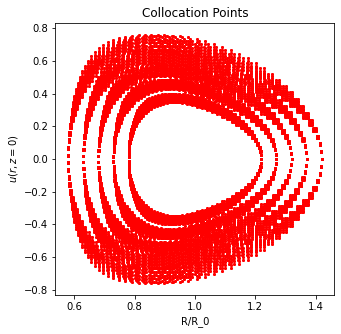

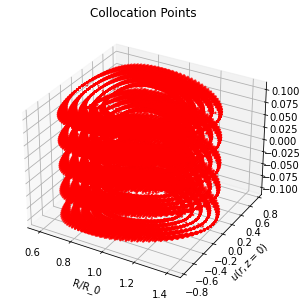

In [3]:
# Plot collocation points for visual check
# %matplotlib

fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

fig =plt.figure(2, figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(data.train_x[:,0], data.train_x[:,1], data.train_x[:,2], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

In [4]:
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)

## Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.097115 s



/Users/alankaptanoglu/deepxde_copy/deepxde/maps/fnn.py:112: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 2.623932 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.11e+00, 7.86e-04]    [1.19e+00, 0.00e+00]    []  
10        [1.88e-01, 3.67e-02]    [3.41e-01, 0.00e+00]    []  
20        [1.02e-01, 5.77e-03]    [2.04e-01, 0.00e+00]    []  
30        [4.36e-02, 1.69e-02]    [6.40e-02, 0.00e+00]    []  
40        [5.75e-03, 7.22e-03]    [8.56e-03, 0.00e+00]    []  
50        [4.08e-03, 5.96e-04]    [6.88e-03, 0.00e+00]    []  
60        [4.61e-03, 7.58e-04]    [6.85e-03, 0.00e+00]    []  
70        [2.70e-03, 7.38e-04]    [4.65e-03, 0.00e+00]    []  
80        [2.35e-03, 6.31e-04]    [4.58e-03, 0.00e+00]    []  
90        [1.78e-03, 4.42e-04]    [3.26e-03, 0.00e+00]    []  
100       [1.36e-03, 3.92e-04]    [2.53e-03, 0.00e+00]    []  

Best model at step 100:
  train loss: 1.76e-03
  test loss: 2.53e-03
  test metric: []

'train' took 129.737716 s

Saving loss history to ./cefron/ITER/runs/network

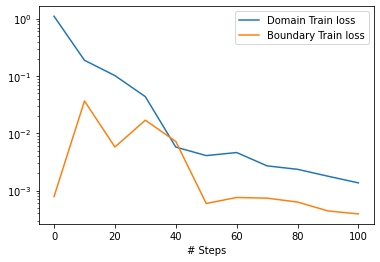

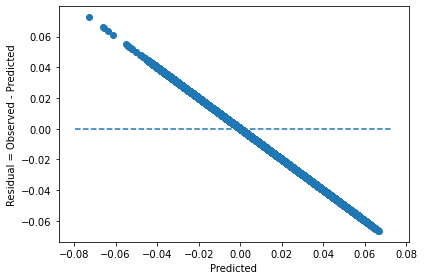

In [5]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-2
DEPTH = 3
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([6] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,1]
  )
  loss_history, train_state = model.train(epochs=100, display_every = 10)
  dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

#### After BFGS

Compiling model...
'compile' took 2.242551 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.36e-03, 3.92e-02]    [2.53e-03, 0.00e+00]    []  
110       [2.44e-03, 1.64e-02]                                
120       [1.61e-03, 3.61e-03]                                
130       [1.06e-03, 3.14e-03]                                
140       [8.19e-04, 2.58e-03]                                
150       [4.66e-04, 2.28e-03]                                
160       [4.59e-04, 1.67e-03]                                
170       [4.57e-04, 1.51e-03]                                
180       [3.61e-04, 1.32e-03]                                
190       [4.12e-04, 1.11e-03]                                
200       [4.02e-04, 1.03e-03]                                
210       [4.84e-04, 8.88e-04]                                
220       [3.77e-04, 7.53e-04]                                
230       [3.45e-04, 6.68e-04]                

1380      [1.08e-05, 1.55e-04]                                
1390      [1.08e-05, 1.54e-04]                                
1400      [1.08e-05, 1.53e-04]                                
1410      [1.07e-05, 1.53e-04]                                
1420      [1.06e-05, 1.53e-04]                                
1430      [1.06e-05, 1.52e-04]                                
1440      [1.05e-05, 1.52e-04]                                
1450      [1.06e-05, 1.52e-04]                                
1460      [1.05e-05, 1.52e-04]                                
1470      [1.05e-05, 1.51e-04]                                
1480      [1.08e-05, 1.49e-04]                                
1490      [1.07e-05, 1.48e-04]                                
1500      [1.07e-05, 1.47e-04]                                
1510      [1.13e-05, 1.45e-04]                                
1520      [1.29e-05, 1.48e-04]                                
1530      [1.15e-05, 1.42e-04]                         

2690      [1.48e-05, 5.54e-05]                                
2700      [1.50e-05, 5.47e-05]                                
2710      [1.50e-05, 5.43e-05]                                
2720      [1.45e-05, 5.44e-05]                                
2730      [1.44e-05, 5.41e-05]                                
2740      [1.45e-05, 5.32e-05]                                
2750      [1.40e-05, 5.33e-05]                                
2760      [1.47e-05, 5.18e-05]                                
2770      [1.49e-05, 5.10e-05]                                
2780      [1.52e-05, 4.97e-05]                                
2790      [1.51e-05, 4.91e-05]                                
2800      [1.59e-05, 4.73e-05]                                
2810      [1.58e-05, 4.67e-05]                                
2820      [1.61e-05, 4.62e-05]                                
2830      [1.61e-05, 4.65e-05]                                
2840      [1.63e-05, 4.53e-05]                         

4000      [7.61e-06, 1.60e-05]                                
4010      [7.59e-06, 1.59e-05]                                
4020      [7.61e-06, 1.57e-05]                                
4030      [7.64e-06, 1.56e-05]                                
4040      [7.69e-06, 1.54e-05]                                
4050      [7.59e-06, 1.54e-05]                                
4060      [7.59e-06, 1.52e-05]                                
4070      [7.63e-06, 1.50e-05]                                
4080      [7.52e-06, 1.50e-05]                                
4090      [7.47e-06, 1.49e-05]                                
4100      [7.52e-06, 1.46e-05]                                
4110      [7.64e-06, 1.44e-05]                                
4120      [7.67e-06, 1.44e-05]                                
4130      [7.55e-06, 1.42e-05]                                
4140      [7.81e-06, 1.38e-05]                                
4150      [7.76e-06, 1.36e-05]                         

5310      [3.77e-06, 7.31e-06]                                
5320      [3.75e-06, 7.32e-06]                                
5330      [3.75e-06, 7.28e-06]                                
5340      [3.77e-06, 7.23e-06]                                
5350      [3.74e-06, 7.24e-06]                                
5360      [3.73e-06, 7.23e-06]                                
5370      [3.73e-06, 7.22e-06]                                
5380      [3.72e-06, 7.22e-06]                                
5390      [3.71e-06, 7.16e-06]                                
5400      [3.67e-06, 7.12e-06]                                
5410      [3.66e-06, 7.11e-06]                                
5420      [3.65e-06, 7.10e-06]                                
5430      [3.65e-06, 7.06e-06]                                
5440      [3.63e-06, 7.04e-06]                                
5450      [3.60e-06, 7.05e-06]                                
5460      [3.60e-06, 7.03e-06]                         

6620      [2.19e-06, 5.45e-06]                                
6630      [2.19e-06, 5.43e-06]                                
6640      [2.19e-06, 5.43e-06]                                
6650      [2.18e-06, 5.42e-06]                                
6660      [2.17e-06, 5.41e-06]                                
6670      [2.18e-06, 5.38e-06]                                
6680      [2.18e-06, 5.36e-06]                                
6690      [2.18e-06, 5.35e-06]                                
6700      [2.18e-06, 5.33e-06]                                
6710      [2.18e-06, 5.32e-06]                                
6720      [2.18e-06, 5.31e-06]                                
6730      [2.18e-06, 5.30e-06]                                
6740      [2.18e-06, 5.29e-06]                                
6750      [2.17e-06, 5.29e-06]                                
6760      [2.17e-06, 5.27e-06]                                
6770      [2.17e-06, 5.26e-06]                         

7930      [1.53e-06, 4.66e-06]                                
7940      [1.53e-06, 4.66e-06]                                
7950      [1.53e-06, 4.66e-06]                                
7960      [1.53e-06, 4.63e-06]                                
7970      [1.52e-06, 4.63e-06]                                
7980      [1.52e-06, 4.62e-06]                                
7990      [1.51e-06, 4.62e-06]                                
8000      [1.51e-06, 4.61e-06]                                
8010      [1.51e-06, 4.61e-06]                                
8020      [1.50e-06, 4.61e-06]                                
8030      [1.48e-06, 4.61e-06]                                
8040      [1.49e-06, 4.60e-06]                                
8050      [1.48e-06, 4.59e-06]                                
8060      [1.48e-06, 4.59e-06]                                
8070      [1.48e-06, 4.59e-06]                                
8080      [1.47e-06, 4.59e-06]                         

9240      [1.17e-06, 4.26e-06]                                
9250      [1.16e-06, 4.25e-06]                                
9260      [1.16e-06, 4.25e-06]                                
9270      [1.16e-06, 4.25e-06]                                
9280      [1.15e-06, 4.25e-06]                                
9290      [1.15e-06, 4.25e-06]                                
9300      [1.15e-06, 4.24e-06]                                
9310      [1.15e-06, 4.24e-06]                                
9320      [1.15e-06, 4.24e-06]                                
9330      [1.14e-06, 4.23e-06]                                
9340      [1.14e-06, 4.23e-06]                                
9350      [1.14e-06, 4.22e-06]                                
9360      [1.14e-06, 4.22e-06]                                
9370      [1.13e-06, 4.22e-06]                                
9380      [1.13e-06, 4.22e-06]                                
9390      [1.13e-06, 4.22e-06]                         

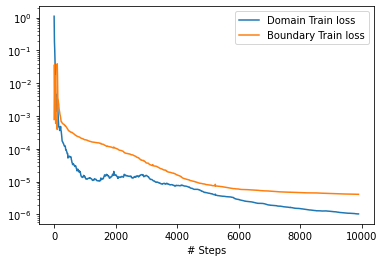

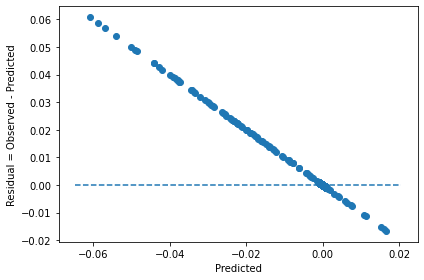

In [6]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


In [7]:
# Evaluation
from utils.utils import evaluate_A, relative_error_plot
#ITER = GS_parametrized(eps0, kappa0, delta0, Amax)
ITER = GS_Linear(eps=eps[0], kappa=kappa[0], delta=delta[0])
full, yfull, A, psi_pred_full, psi_true_full, error = evaluate_A(
    ITER, model, Amax, num_param
)
nx = psi_true_full.shape[0]
ny = psi_true_full.shape[0]
psi_pred_parametrized = np.zeros(
    (nx, ny, num_param, num_param, num_param, num_param)
)
psi_true_parametrized = np.zeros(
    (nx, ny, num_param, num_param, num_param, num_param)
)
for i in range(num_param):
    for j in range(num_param):
        for k in range(num_param):
            ITER = GS_Linear(eps=eps[i], kappa=kappa[j], delta=delta[k])
            xfull, yfull, A, psi_pred_full, psi_true_full, error = evaluate_A(
                ITER, model, Amax, num_param
            )
            psi_pred_parametrized[:, :, :, i, j, k] = psi_pred_full
            psi_true_parametrized[:, :, :, i, j, k] = psi_true_full


(13005, 6)
(1000, 6)
(51, 51, 5)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(

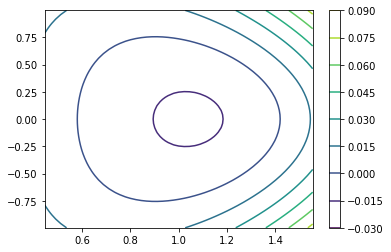

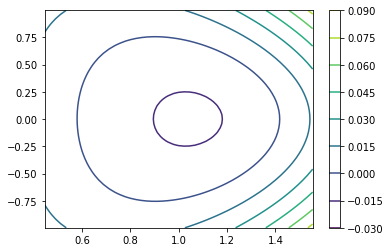

In [8]:
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_true_parametrized[:, :, 0, 0, 0, 0])
plt.colorbar()
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_pred_parametrized[:, :, 0, 0, 0, 0])
plt.colorbar()

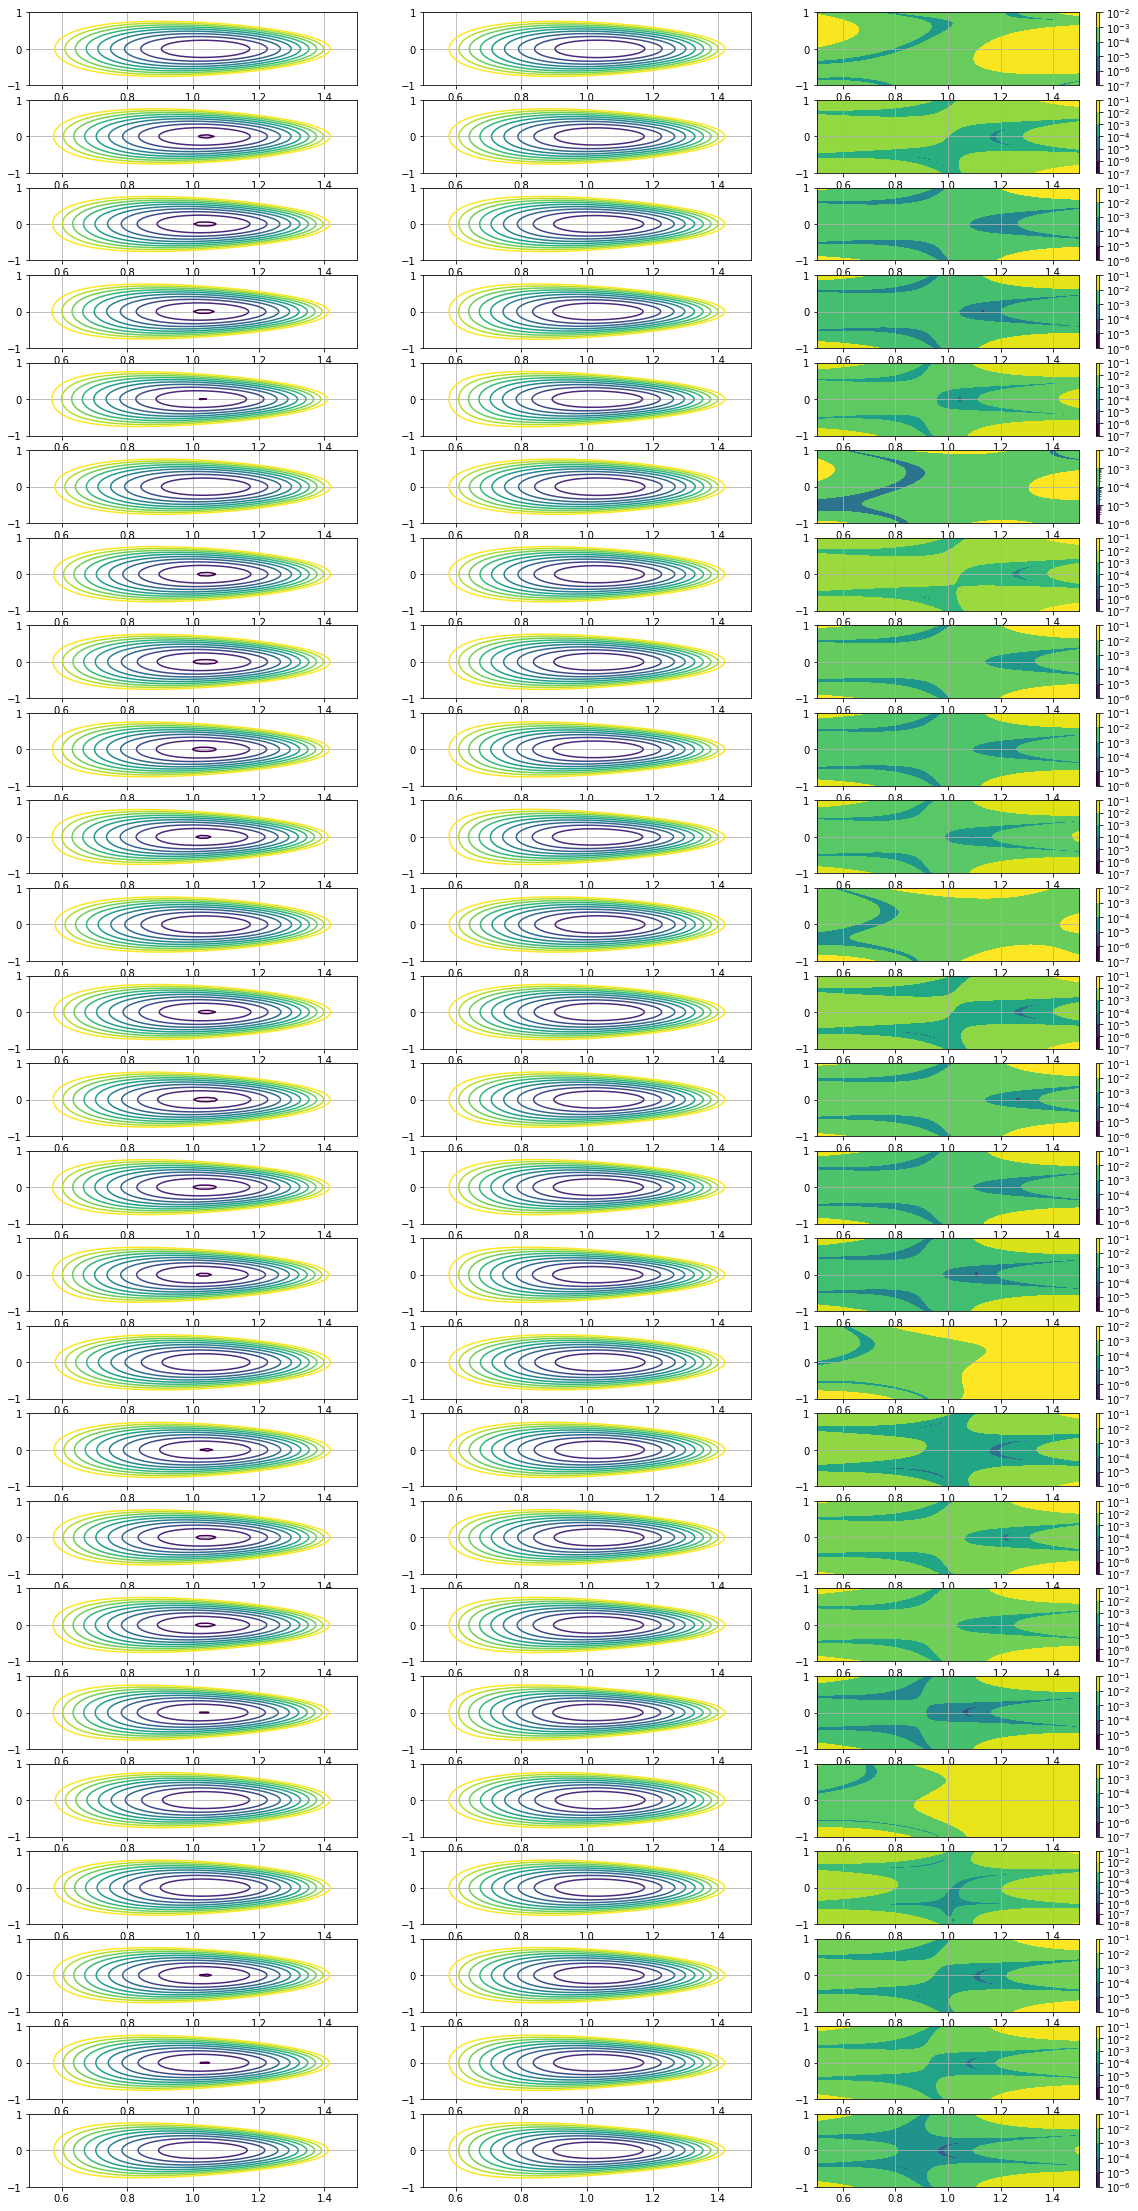

In [16]:
# Plotting Setup
import matplotlib.colors as colors

for i in range(num_param):
    #plt.figure(i + 1, figsize=(10,10))
    for j in range(num_param):
        if i == 0 and j == 0:
            plt.figure(figsize=(20, 40))
            q = 1
            for k in range(num_param):
                for kk in range(num_param):
    #                 zoom = ((1 + eps[j])-(1 - eps[j]))*0.05
    #                 innerPoint = 1 - eps[j] - zoom
    #                 outerPoint = 1 + eps[j] + zoom
    #                 lowPoint   = -kappa[k] * eps[j] - zoom
    #                 highPoint  = kappa[k] * eps[j] + zoom
                    innerPoint = 0.5
                    outerPoint = 1.5
                    lowPoint = -1
                    highPoint = 1
                    plt.subplot(num_param ** 2, 3, q)
                    levels = np.linspace(
                        min(psi_true_parametrized[:, :, i, j, k, kk].reshape(-1)), 0, 10
                    )    
                    cp = plt.contour(
                        xfull[:, :, i], yfull[:, :, i], 
                        psi_pred_parametrized[:, :, i, j, k, kk],
                        levels=levels
                    )
                    plt.grid(True)
                    plt.axis(
                        xmin=innerPoint,
                        xmax=outerPoint,
                        ymin=lowPoint, 
                        ymax=highPoint
                    )
                    plt.subplot(num_param ** 2, 3, q + 1)
                    cp = plt.contour(
                        xfull[:, :, i], 
                        yfull[:, :, i], 
                        psi_true_parametrized[:, :, i, j, k, kk],
                        levels=levels
                    )
                    plt.grid(True)
                    plt.axis(
                        xmin=innerPoint,
                        xmax=outerPoint,
                        ymin=lowPoint, 
                        ymax=highPoint
                    )
                    plt.subplot(num_param ** 2, 3, q + 2)
                    errors = abs(psi_true_parametrized[:, :, i, j, k, kk] - psi_pred_parametrized[:, :, i, j, k, kk]) / np.max(
                            abs(psi_true_parametrized[:, :, i, j, k, kk]))
                    cp = plt.contourf(
                        xfull[:, :, i], 
                        yfull[:, :, i], 
                        errors,
                        norm=colors.LogNorm(vmin=errors.min(), 
                                            vmax=errors.max()),
                        #levels=levels
                    )
                    plt.grid(True)
                    plt.axis(
                        xmin=innerPoint,
                        xmax=outerPoint,
                        ymin=lowPoint, 
                        ymax=highPoint
                    )
                    plt.colorbar()
                    q = q + 3

In [30]:
import time 

nx = 30
ny = nx
zoom = 0.2
inner_point = (1 - 1.1*ITER.eps*(1+zoom))
outer_point = (1 + 1.1*ITER.eps*(1+zoom))
high_point  = (1.1*ITER.kappa * ITER.eps*(1+zoom) )
low_point   = (-1.1*ITER.kappa * ITER.eps*(1+zoom) )
x, y, A = np.meshgrid(
    np.linspace(inner_point, outer_point, nx),
    np.linspace(low_point, high_point, ny),
    np.linspace(-Amax, Amax, num_param),
    indexing='ij'
)
ones = np.ones(nx * ny * num_param)

X = np.vstack((
    np.ravel(x), np.ravel(y), np.ravel(A),
    ITER.eps * ones, ITER.kappa * ones, ITER.delta * ones
)).T
print(X.shape)
t1 = time.time()
model.predict(X)
t2 = time.time()
print(t2 - t1)

(4500, 6)
0.009846925735473633
